# Plant Seedlings Classification
## Determine the species of a seedling from an image

1. Choosing learning rate
1. Data augmentation



1. recompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96

In [3]:
#PATH = "../../data/plant_seeding_clf/"
PATH = f'../../data/plant_seedling_classify/'
sz=224

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

NameError: name 'PWD' is not defined

In [23]:
os.listdir(PATH)


['sample_submission.csv', 'test', 'train']

In [26]:
folders = os.listdir(f'{PATH}train')
folders

['Cleavers',
 'Sugar beet',
 'Scentless Mayweed',
 'Loose Silky-bent',
 'Maize',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Charlock',
 'Common wheat',
 'Black-grass',
 'Common Chickweed']

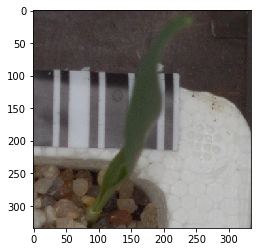

In [27]:
files = os.listdir(f'{PATH}test')
img = plt.imread(f'{PATH}test/{files[0]}')
plt.imshow(img);

In [28]:
def copy_or_move_with_subdirs(subdir_lst, src, dst, r, move=False):
    do = shutil.move if move else shutil.copy
    for subdir in subdir_lst:
        os.makedirs(os.path.join(dst, subdir))
        files = glob(os.path.join(src, subdir, '*'))
        np.random.shuffle(files)
        for f in files[:int(len(files) * r)]:
            do(f, os.path.join(dst, subdir, os.path.split(f)[1]))

In [29]:
def create_val(path, folders, r):
    """ Takes a path to a dataset and creates a validation set of specified size

    Note - this changes the dataset at <path> by moving files to the val set

    Parameters:
    -----------
    path: dataset path
    r (float): proportion of examples to use for validation, in the range from 0 to 1

    """
    val_path = os.path.join(os.path.split(path)[0], 'valid')
    dump_path = os.path.join(os.path.split(path)[0], 'dump')
    subdirs = [os.path.split(p)[1] for p in glob(os.path.join(path + 'train/', '*'))]
    # in prod need set move=True
    copy_or_move_with_subdirs(subdirs, path + 'train/', dump_path, r, move=False)
    copy_or_move_with_subdirs(subdirs, path + 'train/', val_path, r, move=True)

In [30]:
if not os.path.isdir(f'{PATH}valid'):
    print('Create valid data set')
    create_val(f'{PATH}', folders, 0.2)

Create valid data set


In [31]:
os.listdir(PATH)

['dump', 'sample_submission.csv', 'test', 'valid', 'train']

In [13]:
#TODO: here need check mulival clf
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

In [33]:
img.shape

(334, 334, 3)

In [34]:
data.val_y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3

In [35]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [36]:
log_preds = learn.predict()
log_preds.shape

(947, 12)

Select lern rate

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
lrf=learn.lr_find()

 87%|████████▋ | 52/60 [00:00<00:00, 57.24it/s, loss=2.49]


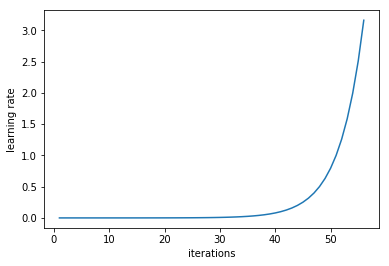

In [39]:
learn.sched.plot_lr()

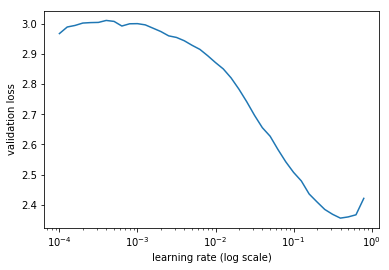

In [40]:
learn.sched.plot()

In [ ]:
Augmentation transform

In [8]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [9]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [10]:
ims = np.stack([get_augs() for i in range(6)])

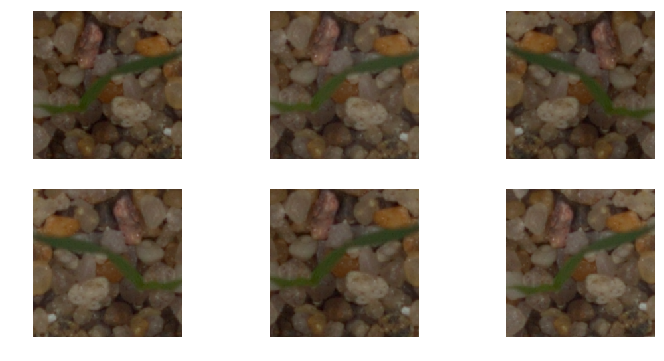

In [11]:
plots(ims, rows=2)

In [41]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 13/13 [00:02<00:00,  5.06it/s]


In [16]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.58072    0.876982   0.726505  



[array([0.87698]), 0.7265047523514648]

In [17]:
learn.precompute=False

In [18]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.078914   0.776653   0.7434    
    1      1.002803   0.714746   0.75396                   
    2      0.926151   0.663431   0.778247                  



[array([0.66343]), 0.7782470964076275]

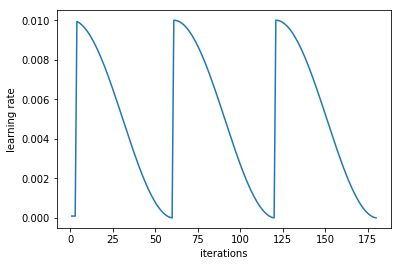

In [19]:
learn.sched.plot_lr()

In [50]:
learn.save('224_lastlayer')

In [20]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

In [42]:
learn.unfreeze()

In [43]:
lr=np.array([1e-4,1e-3,1e-2])

In [44]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.767796   1.189751   0.618796  
    1      1.335019   0.818967   0.734952                 
    2      1.091573   0.778711   0.752904                 
    3      0.96112    0.665081   0.788807                  
    4      0.873902   0.626877   0.779303                  
    5      0.802104   0.588858   0.80359                   
    6      0.752254   0.589388   0.799366                  



[array([0.58939]), 0.7993664206521942]

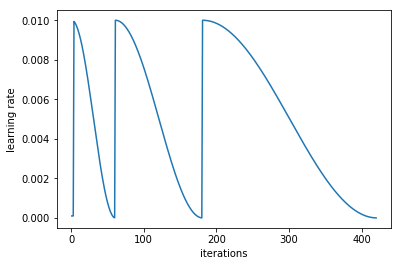

In [24]:
learn.sched.plot_lr()

In [56]:
learn.save('224_all')

In [45]:
learn.load('224_all')

In [46]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [47]:
accuracy_np(probs, y)

0.9472016895459345

In [48]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

### Create submision

In [29]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [62]:
#data.test_ds.fnames
data.test_ds.fnames

['test/79e5ea8fa.png',
 'test/3a909ead8.png',
 'test/599691cd9.png',
 'test/5ca2687a4.png',
 'test/3dd52bd2a.png',
 'test/1541bdb2e.png',
 'test/39d569be4.png',
 'test/3d65168c2.png',
 'test/995c7ab1e.png',
 'test/99569b224.png',
 'test/8d6acbe9b.png',
 'test/aee6fa3df.png',
 'test/5b63dcc21.png',
 'test/219fd68d5.png',
 'test/69d1669f8.png',
 'test/82b5f4d33.png',
 'test/35ebe165c.png',
 'test/aad8375e0.png',
 'test/1376f3b63.png',
 'test/728eabae1.png',
 'test/0c51bf229.png',
 'test/cf3a8b2fd.png',
 'test/60f0bc617.png',
 'test/4e18ab737.png',
 'test/3fbd0fc6a.png',
 'test/cf46d09c5.png',
 'test/558aa7deb.png',
 'test/b03397525.png',
 'test/1bf9b94a6.png',
 'test/2a667e099.png',
 'test/5bd71f445.png',
 'test/b39c71707.png',
 'test/752101fdf.png',
 'test/1d0cbd819.png',
 'test/3da774107.png',
 'test/a276c65f7.png',
 'test/d2f422ccb.png',
 'test/466bb6d3b.png',
 'test/77ccb8b2a.png',
 'test/2f246d688.png',
 'test/65e97117e.png',
 'test/e5e3dccff.png',
 'test/e80a259c5.png',
 'test/da52

In [50]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)

In [51]:
probs.shape # (n_images, n_classes)

(794, 12)

In [111]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [112]:
df['species'] = df.idxmax(axis=1)

In [113]:
df.insert(0, 'file', [o[5:] for o in data.test_ds.fnames])

In [114]:
df.head()

,file,Black-grass,Charlock,Cleavers,Common Chickweed,Common wheat,Fat Hen,Loose Silky-bent,Maize,Scentless Mayweed,Shepherds Purse,Small-flowered Cranesbill,Sugar beet,species
0,79e5ea8fa.png,0.010825,0.002738,0.000072,0.000030,9.753295e-01,0.001669,4.613216e-04,0.007551,1.348792e-04,4.958631e-06,0.000004,1.180839e-03,Common wheat
1,3a909ead8.png,0.000002,0.000030,0.000057,0.000028,5.302343e-07,0.000003,2.576855e-06,0.000007,1.491889e-06,3.433989e-04,0.999526,5.640070e-08,Small-flowered Cranesbill
2,599691cd9.png,0.000002,0.000003,0.000004,0.000077,2.750086e-07,0.000004,3.601641e-06,0.000004,6.180867e-07,5.823981e-04,0.999317,1.465343e-07,Small-flowered Cranesbill
3,5ca2687a4.png,0.000006,0.006538,0.000002,0.000002,8.296485e-04,0.000055,1.739788e-07,0.992532,1.016936e-08,3.188595e-07,0.000003,3.368391e-05,Maize
4,3dd52bd2a.png,0.000004,0.000481,0.000159,0.000391,1.122843e-06,0.000015,7.409931e-06,0.000011,9.364570e-05,1.098136e-02,0.987855,7.698745e-07,Small-flowered Cranesbill


In [116]:
result = df[['file', 'species']]
result.head()

,file,species
0,79e5ea8fa.png,Common wheat
1,3a909ead8.png,Small-flowered Cranesbill
2,599691cd9.png,Small-flowered Cranesbill
3,5ca2687a4.png,Maize
4,3dd52bd2a.png,Small-flowered Cranesbill


In [117]:
#file,species
SUBM = f'subm/'
os.makedirs(SUBM, exist_ok=True)
result.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [118]:
FileLink(f'{SUBM}subm.gz')

/home/paperspace/fastai/fastai_learn/subm/subm.gz